In [1]:
import os
from PIL import Image

def find_non_images(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            try:
                Image.open(path)
            except:
                print(f"Fișier problematic: {path}")

find_non_images("data/train")
find_non_images("data/val")


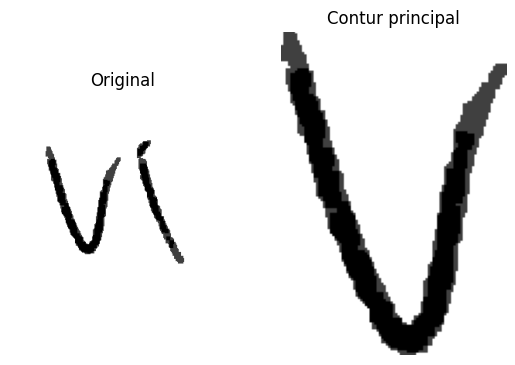

In [31]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def extract_main_contour(img):
    # 1️⃣ Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape)==3 else img

    # 2️⃣ Adaptive Threshold
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 4)

    # 3️⃣ Morphology: elimina zgomot
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # 4️⃣ Detect contururi externe
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # 5️⃣ Filtrare contururi dupa arie si raport aspect
    valid_contours = []
    h, w = binary.shape
    for c in contours:
        x, y, cw, ch = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        aspect_ratio = cw / float(ch)
        if 50 < area < 0.95*h*w and 0.1 < aspect_ratio < 10:  # ajustabil
            valid_contours.append(c)

    if not valid_contours:
        return None, None

    # 6️⃣ Selectam conturul principal (cel mai mare)
    main_contour = max(valid_contours, key=cv2.contourArea)

    # 7️⃣ Creare mask si extragerea ROI
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [main_contour], -1, 255, -1)
    x, y, w, h = cv2.boundingRect(main_contour)
    roi = gray[y:y+h, x:x+w]

    return roi, mask

# Exemplu de test
img_path = "data/train/vi/aac04d60-ce5d-11eb-b317-38f9d35ea60f.png"
img = cv2.imread(img_path)
roi, mask = extract_main_contour(img)

if roi is not None:
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(roi, cmap='gray')
    plt.title("Contur principal")
    plt.axis('off')
    plt.show()
else:
    print("Nu s-a găsit contur valid.")
